# Assignment 06

## Dimensionality Reduction 

## CSCI S-96

### Steve Elston

> Instructions: For this assignment you will complete the exercises shown. All exercises involve creating and executing some Python code. Additionally, most exercises have questions for you to answer. You can answer questions by creating a Markdown cell and writing your answer. If you are not familiar with Markdown, you can find a brief tutorial here.

## Introduction  

Dimensionality reduction algorithms are widely used in data mining. Human perception of relationships in data is limited beyond a few dimensions. Further, many data mining algorithms produce poor results where when there is significant dependency between the features or variables. In both cases, we can apply dimensionality reduction methods.   

In the exercises in this notebook you will gain some experience working with some commonly used dimensionality reduction methods. Specifically, there are two distinct classes of algorithms you will explore:    
1. **Dimensionality reduction transformation methods** create operators to map a sample (feature) space to an orthogonal space. Typically the original data can be well-represented in lower dimensions in the orthogonal space. Examples of these methods include principle component analysis (PCA) and kernel principle component analysis (Kernal PCA).    
2. **Manifold learning methods** where data in a high dimensional space is mapped onto a 2-dimensional manifold. Manifold learning is primarily used to aid visualization of high-dimensional data.  

To begin, execute the code in the cell below to import the packages you will need. 

In [6]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, MDS
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

## A Synthetic Example

To make the ideas of dimensionality reduction clear, we start with an extremely simple example. In this example, dimensionality reduction is applied to bivariate Normally distributed data. The code in the cell below does the following:  
1. Generate 500 samples from a bivariate, zero-centered Normal distribution with covariance having a high degree of dependency between the variables:  
$$
cov = 
 \begin{bmatrix}
   1.0 & 0.9\\
   0.9 & 1.0
   \end{bmatrix}
$$
2. Print the empirical covariance matrix of the sample.  
3. Plot the simulated data values.

Execute this code.

The emperical covariance
[[1.02657695 0.91440274]
 [0.91440274 0.99100602]]


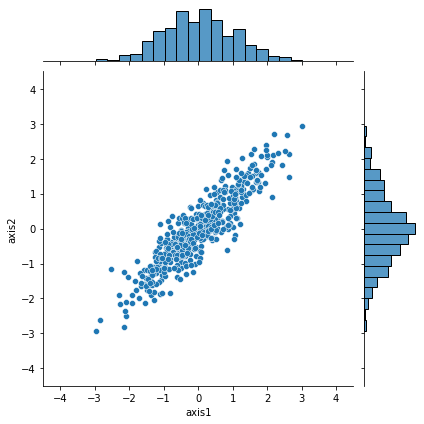

In [7]:
def plot_normal(X):
    X = pd.DataFrame(X, columns=['axis1','axis2'])
    _=sns.jointplot(x='axis1', y='axis2', data=X, xlim=(-4.5,4.5), ylim=(-4.5,4.5))

cov = [[1, 0.9], [0.9, 1]]
np.random.seed(367)
Normal_random = np.random.multivariate_normal([0.0,0.0], cov, size=500)
print('The emperical covariance')
print(np.cov(Normal_random[:,0], Normal_random[:,1]))
plot_normal(Normal_random)

Notice the following aspects of these results:  
1. The empirical covariance matrix is very close in values to the covariance matrix used for the simulation.   
2. The scatter plot shows considerable dependency between the two variables. 
3. The marginal distributions of the two variables appear to be close to Normally distributed. 

Next, the code in the cell below does the following.  
1. A PCA object is instantiated and the data fit.   
2. The PCA model is used to transform or project the original data matrix into the new coordinate system.    
3. The empirical covariance is computed and printed. 
4. **Variance ratio** of the two dimensions of the new space is computed and printed. Here, variance ratio is the variance on each dimension of the space divided by the total variance of the data. 
5. A plot of the projected data values in the new coordinate space is plotted. 

Execute this code. 

Covariance of the transformed data
[[1.92336718e+00 1.31713834e-16]
 [1.31713834e-16 9.42157896e-02]]

The variance explained ratio = [0.95330264 0.04669736]


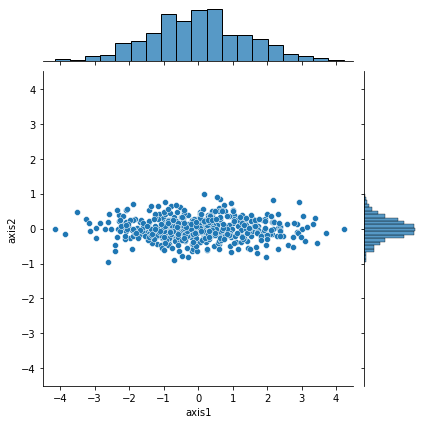

In [8]:
Normal_pca = PCA().fit(Normal_random)
simple_pca = Normal_pca.transform(Normal_random)
print('Covariance of the transformed data')
print(np.cov(simple_pca[:,0], simple_pca[:,1]))
print(f"\nThe variance explained ratio = {Normal_pca.explained_variance_ratio_}")
plot_normal(simple_pca)

The PCA transformation of these data appears to have worked as expected. Notice the following:  
1. The diagonal terms of the covariance matrix are significantly different in value, indicating that the first component (axis) projects the majority of the variance of the data.  
2. The off-diagonal terms of the covariance matrix are effectively 0, indicating there is no dependency between the variables in the new coordinate system. 
3. The observation that most of the variability of the projected data are explained by the first component is confirmed by both the variance ratio values and the scatter plot. 
4. The marginal distributions of the two variables are very close to Normal, but with significantly difference scale or variance. 

## First Running Example  

We will now start working with some simple real-world data. The famous Iris dataset was collected by a botanist named Edgar Anderson around 1935. Subsequently, the dataset became famous in data analysis circles when Ronald A Fisher used it as an example for his seminal 1936 paper on discriminate analysis, one of the first true multivariate statistical methods proposed. By modern standards this data set is small (only 150 samples) and simple (only 4 features), but the simplicity will help in understand the methods at hand.   

The code in the cell below loads the data set and transforms it into a de-meaned Pandas data frame with human readable column and species names. Execute this code. 

In [9]:
iris_data = load_iris()

## Demean the data columns 
temp = np.zeros(iris_data['data'].shape)
for i in range(iris_data['data'].shape[1]): 
    temp[:,i] = np.subtract(iris_data['data'][:,i], np.mean(iris_data['data'][:,i], axis=0))

## Prepare the data frame 
target_species = {0:'Setosa',1:'Versicolour',2:'Virginica'}
species = [target_species[x] for x in iris_data['target']]
iris = pd.DataFrame(temp, columns=['sepal_length','sepal_width','petal_length','petal_width'])
iris['species'] = species
iris_data = iris_data['data']
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,-0.743333,0.442667,-2.358,-0.999333,Setosa
1,-0.943333,-0.057333,-2.358,-0.999333,Setosa
2,-1.143333,0.142667,-2.458,-0.999333,Setosa
3,-1.243333,0.042667,-2.258,-0.999333,Setosa
4,-0.843333,0.542667,-2.358,-0.999333,Setosa
...,...,...,...,...,...
145,0.856667,-0.057333,1.442,1.100667,Virginica
146,0.456667,-0.557333,1.242,0.700667,Virginica
147,0.656667,-0.057333,1.442,0.800667,Virginica
148,0.356667,0.342667,1.642,1.100667,Virginica


Since there are only 4 features in this dataset a pairs plot will help with understanding the relationships in these data. Execute the code below to display the plot. 

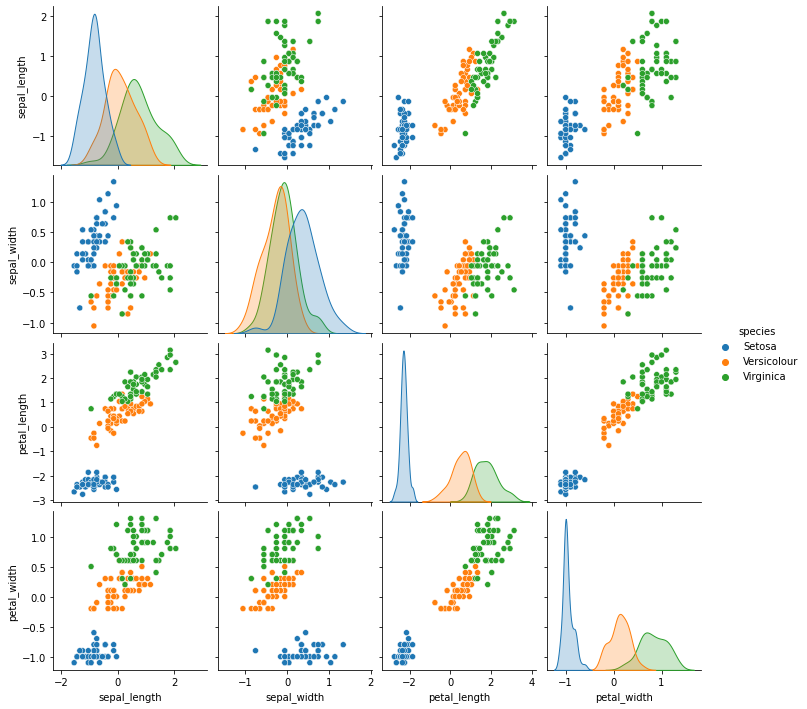

In [10]:
_=sns.pairplot(iris, hue='species')

Examine this plot array. You can see that values samples for the Setosa species are well separated. However there is some overlap between samples from Versicolour and Virginica. Further, and more importantly, it appears that these is considerable redundancy in these plots. This leads one to suspect that there is a high dependency between these cases.  

We can further investigate the dependency between the variables by computing the covariance matrix. Execute the code in the cell below to compute the covariance matrix of the iris data. 

Iris covariance matrix
              sepal_length  sepal_width  petal_length  petal_width
sepal_length      0.685694    -0.042434      1.274315     0.516271
sepal_width      -0.042434     0.189979     -0.329656    -0.121639
petal_length      1.274315    -0.329656      3.116278     1.295609
petal_width       0.516271    -0.121639      1.295609     0.581006


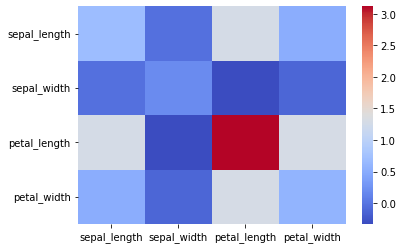

In [11]:
iris_convariance = pd.DataFrame(np.cov(np.transpose(iris_data)), index=list(iris.columns)[:-1], columns=list(iris.columns)[:-1])
print('Iris covariance matrix')
print(iris_convariance)
sns.heatmap(iris_convariance, cmap='coolwarm');

Several of the off-diagonal terms of the covariance matrix are far from zero. We can conclude that there is significant dependency between the variables.   

## Compute PCA of the iris data   

The first algorithm you will apply to the iris data is linear PCA.  

> **Exercise 06-1:** Compute the PCA of the iris data and plot the explained variance of the components by the following steps:  
> 1. Instantiate a Scikit-learn PCA model object with [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  
> 2. Fit the model to `iris_data` numpy array using the `fit` method on the model object (note that sklearn methods expect Numpy arrays as arguments, not Pandas Data frames).  
> 3. Create a scatter plot of the `explained_variance_ratio_` attribute of the fitted model vs. the component number.  `

In [1]:
## Put your code below 







> Examine the plot and answer these questions: 
> 1. Does it appear that much of the variance in the data is explained by the first component and why?  
> 2. Is there any substantial difference in the variance explained between the second and third and fourth components?   

> **Answers:**    
> 1.       
> 2.      

> Recall that the variance of the components from the PCA goes as the square of the singular values. You can gain another view of the relationship between the principle components by executing the code below to plot the singular values. 

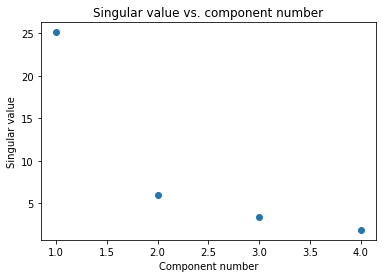

In [13]:
_=plt.scatter(range(1, len(iris_pca.singular_values_) + 1), iris_pca.singular_values_)
_=plt.xlabel('Component number')
_=plt.ylabel('Singular value')
_=plt.title('Singular value vs. component number')

> 3. Are these singular values consistent with the variance explained for the components? 
> **End of exercise.**

> **Answer:**         

Next, you will investigate the principle components used to project the data into the new space. Execute the code in the cell below to print the components.  

In [14]:
components = iris_pca.components_
components

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143],
       [-0.31548719,  0.3197231 ,  0.47983899, -0.75365743]])

> **Exercise 06-2:** The principle components must be unitary, unit norm, and orthogonal. Do the following to verify these properties.  
> 1. In the first cell below compute and print the Euclidean norm of these of the components using [numpy.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).    
> 2. Using [itertools.combinations](https://docs.python.org/3/library/itertools.html) compute the dot (inner) product of each of pairwise combination of the components using [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) in the second cell below. 

In [15]:
print('The euclidean norm of the components:')
## Put your code below 


    
print('\nThe dot products between the components:')    
## Put your code below 




The euclidean norm of the components:
The Euclidean norm of component  0 =   1.00
The Euclidean norm of component  1 =   1.00
The Euclidean norm of component  2 =   1.00
The Euclidean norm of component  3 =   1.00

The dot products between the components:
For componets  0,  1 the dot prodcut =  0.000
For componets  0,  2 the dot prodcut =  0.000
For componets  0,  3 the dot prodcut =  0.000
For componets  1,  2 the dot prodcut = -0.000
For componets  1,  3 the dot prodcut = -0.000
For componets  2,  3 the dot prodcut =  0.000


> Examine these results. Are these components orthogonal and unitary and how can you tell?   
> **End of exercise.**

> **Answers:**           

> **Exercise 06-3:** From the initial exploration of the variance explained and singular values it is the case that a few components can explain most of the variance. To project the 4-dimensional data space to a lower dimensional space do the following:   
> 1. Examine the break in the curve for both the explained variance and singular values. This breakpoint determines the number of components you should use for the projection. 
> 2. Instantiate the projected data array using a PCA model object, using the `n_components` arguments and using the `fit_transform` method on the `iris_data`.   
> 3. Plot the transformation of the data with the `plot_pca` function provided. Make sure you save the returned data frame as `pca_projected`.  

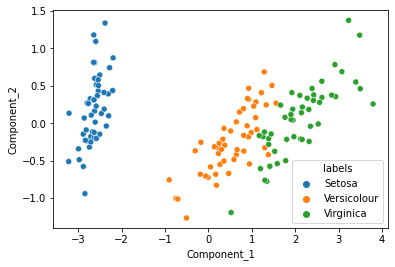

In [16]:
def plot_pca(X, labels):
    pca_projected = pd.DataFrame(X, columns=['Component_1','Component_2'])
    pca_projected['labels'] = labels 
    sns.scatterplot(data=pca_projected, x='Component_1', y='Component_2', hue='labels')
    return pca_projected

## Put your code below 



> Examine the plot you have created. Answer the following questions:  
> 1. How well can these clusters be linearly separated and thereby separating the specie classes and why?  
> 2. Notice the different scales of the two projected variables. Is the range of values of the components consistent with the variance of the components?    


> **Answers:**       
> 1.       
> 2.    .       

> We can check the independence of the components by computing the covariance. In the cell below create and execute code to . to display the covariance of the projected components. 

In [17]:
## Put your code below. 


array([[4.22824171e+00, 1.95148382e-17],
       [1.95148382e-17, 2.42670748e-01]])

> 3. Notice the small values of the off-diagonal components. Do these values indicate the components are orthogonal.
> **End of Exercise.**

> **Answer:**     

## Second Example Dataset

The bowl disease gene dataset has high dimensionality, with over 10,000 features. The question is can this high dimensional space be projected to a lower dimensional space.   

Execute the code in the cell below to load the data set and prepare it for analysis. 

In [18]:
gene_data = pd.read_csv('../data/ColonDiseaseGeneData-Cleaned.csv')
labels = gene_data.loc[:,'Disease State']
gene_data = gene_data.drop('Disease State', axis=1)

## Demean the columns 
for col in gene_data.columns: 
    gene_data.loc[:,col] = gene_data.loc[:,col].subtract(gene_data.loc[:,col].mean(axis=0))

## Display the results 
print(gene_data.shape)
print(gene_data.head())

(97, 10497)
    FAM138F  LOC100133331  LOC100132062  LOC388312  BC016143  BC071797  \
0  0.010857     -0.108726     -0.225302  -0.337102 -0.311806  0.808472   
1  0.787957     -0.320126     -0.224602  -0.148002 -0.225706 -0.156328   
2 -0.441343      0.151674      0.192898   0.309898 -0.127306  0.817072   
3  0.363557     -0.489926     -0.718602  -0.772502  0.051094 -0.438028   
4  0.065257     -0.232226     -0.340102  -0.444402 -0.220606 -0.018628   

   AX746564  LINC00623    FAM45B      DUX4  ...     TTLL3     TTLL4     TTLL5  \
0 -0.100301   0.217659  0.173582  0.016549  ...  0.021406 -0.069732  0.105259   
1 -0.084701   0.049459 -0.058118  0.364849  ... -0.001994 -0.133232 -0.018641   
2  0.002699   0.207559  0.314082 -0.111251  ... -0.047194  0.130268  0.351359   
3  0.079799  -0.720941  0.658382  0.621749  ...  0.146506  0.062368 -0.116641   
4 -0.360001  -0.197141 -0.328818 -0.305751  ...  0.007206  0.097368 -0.049541   

      TTLL6     TTLL7     TTLL9   UGT2B17   UGT2B28    U

For the 97 subjects there are gene expression values for over 10,000 genes.  

> **Exercise 06-4:** You will now explore the ability of PCA to reduce the dimensionality of the genetics data. To test this idea do the following:   
> 1. Instantiate a PCA object and apply the `fit` method with the `gene_data` as the argument.  
> 2. Print the cumulative sum of the variance explained by applying the [numpy.cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) function to the `explained_variance_ratio_` attribute of the model object. 
> 2. Plot the first 20 components of the `explained_variance_ratio_` attribute of the model object vs. the component number. 
> 3. Execute your code. 

[0.28591992 0.48657738 0.56041794 0.60467475 0.63629561 0.66105591
 0.68216765 0.70120389 0.71618649 0.73065404 0.74262297 0.75387166
 0.76361371 0.77312069 0.781407   0.7891725  0.79646659 0.8036023
 0.81054344 0.81692207 0.82279541 0.82844267 0.83362836 0.83870347
 0.84351318 0.84801253 0.85233806 0.85659059 0.86058358 0.86450969
 0.86836703 0.87202997 0.87546406 0.87881369 0.88209975 0.88530617
 0.88847495 0.89158825 0.89462418 0.89760378 0.90049965 0.90327249
 0.90600867 0.90871149 0.91139785 0.91403808 0.9165884  0.91910679
 0.92159068 0.92399243 0.92635651 0.92869632 0.93101047 0.93323699
 0.93544811 0.9376186  0.93976099 0.94188285 0.94393321 0.94595399
 0.94792969 0.94986541 0.9517798  0.95365987 0.95548568 0.95728616
 0.95907676 0.96084583 0.96258822 0.9643053  0.96598294 0.96764607
 0.96929003 0.97090066 0.97249849 0.97407221 0.9756115  0.97711743
 0.97860413 0.98007513 0.98153219 0.98297179 0.9843754  0.98575056
 0.98711315 0.98846672 0.98974622 0.99101546 0.99226138 0.99347

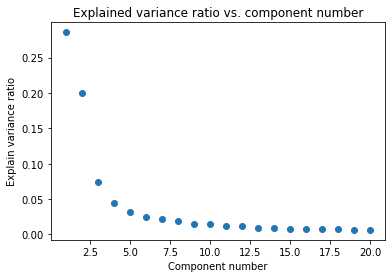

In [19]:
## Put your code below 




n_components = 20
_=plt.scatter(range(1, n_components+1), gene_pca.explained_variance_ratio_[:n_components])
_=plt.xlabel('Component number')
_=plt.ylabel('Explain variance ratio')
_=plt.title('Explained variance ratio vs. component number')

> Study your plot. Notice that the explained variance ratio decreases rapidly with the component number. Answer the following questions:  
> 1. From the cumulative sums of the variance explained, approximately how many components would you estimate are required to account for over 70% over the variance?  
> 2. Does the decay of the variance explained curve indicate that dimensionality reduction can be significant?   

> **Answers:**    
> 1.           
> 2.      

> Now you will display and examine a pairwise scatter plot of the first components of the PCA decomposition of the genetics data. Complete the code below with the number of components representing a cumulative 70% of the variance. Execute your code to display the plot.   

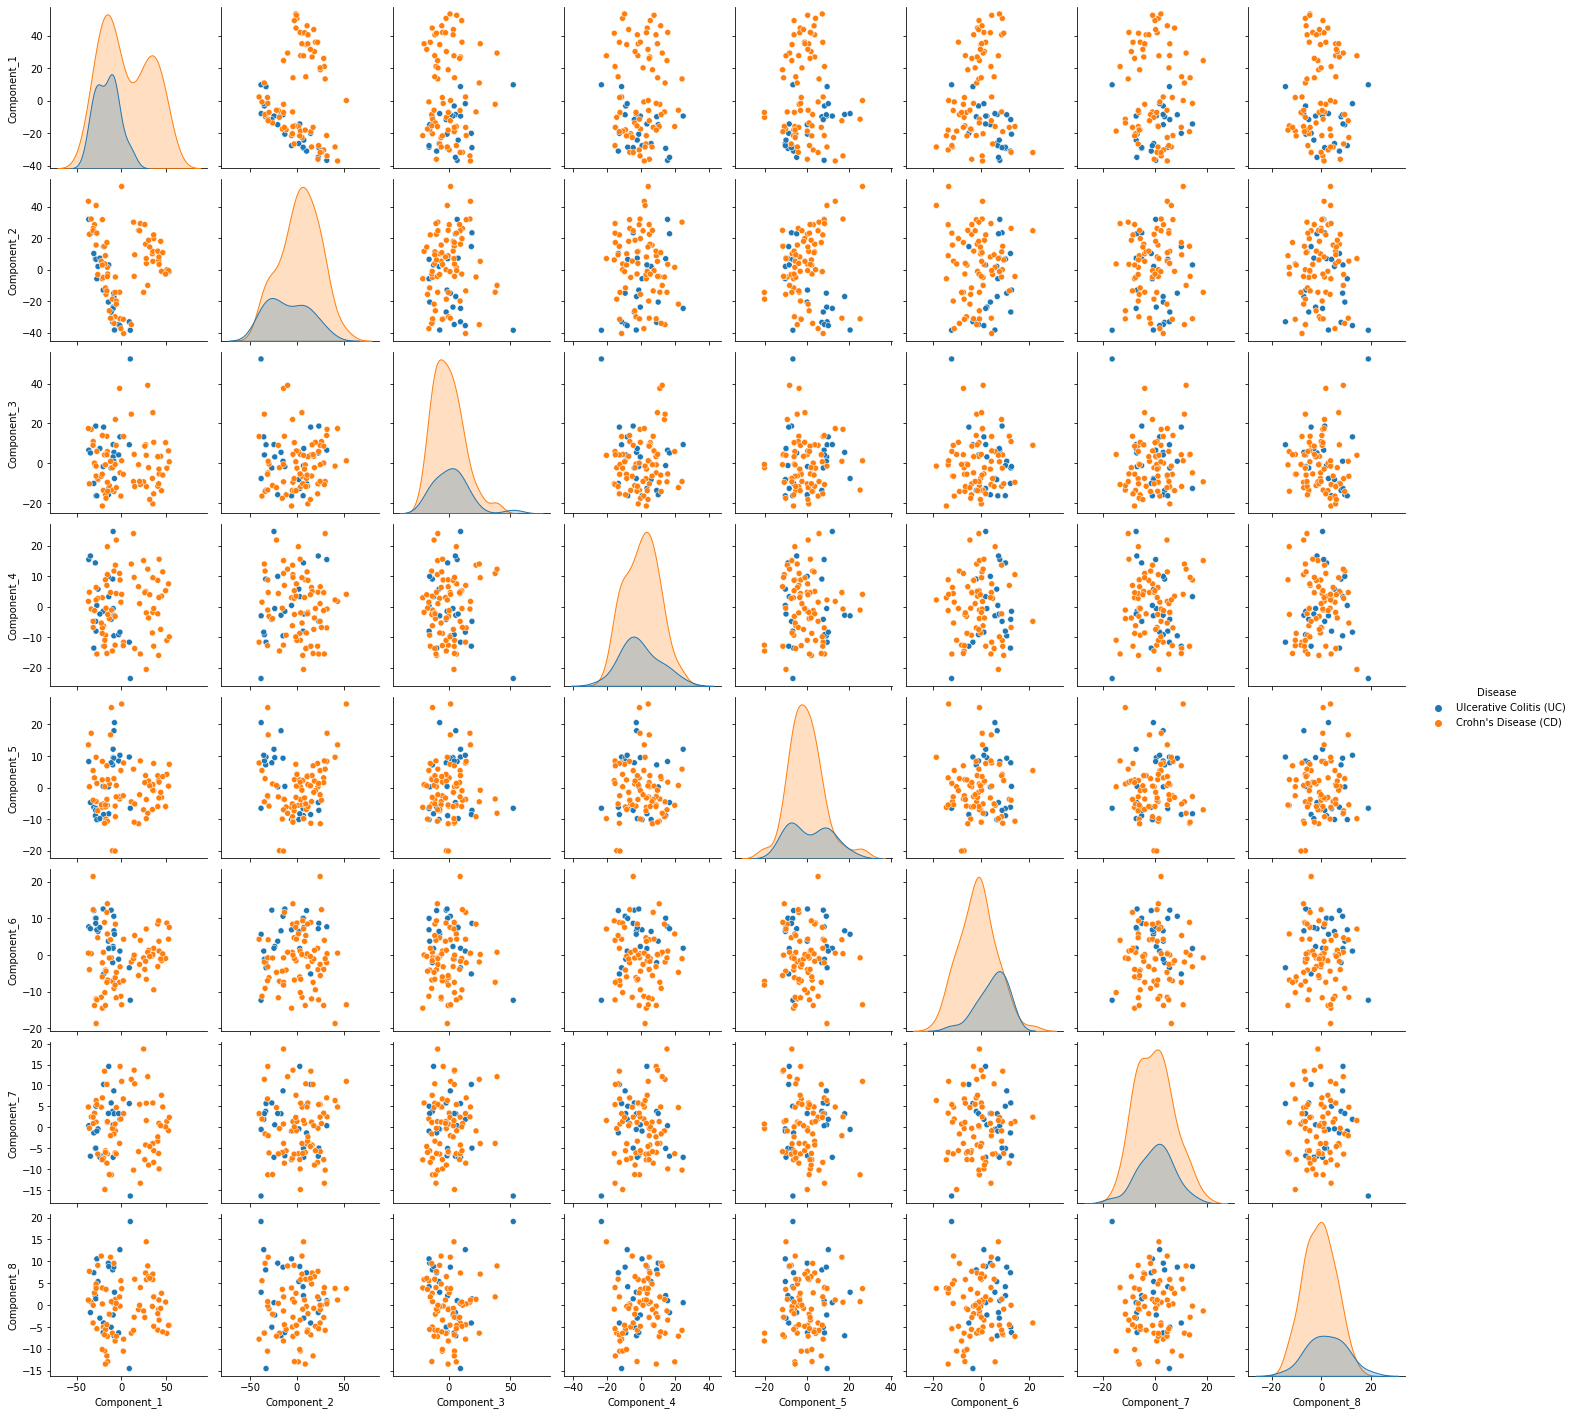

In [20]:
## Complete the code below   
n_components =  

gene_pca_8 = PCA(n_components=n_components).fit(gene_data)
gene_pca_projected = pd.DataFrame(gene_pca_8.transform(gene_data), columns=['Component_1','Component_2','Component_3','Component_4','Component_5','Component_6','Component_7','Component_8'])
gene_pca_projected['Disease'] = labels
_=sns.pairplot(gene_pca_projected, hue='Disease')

> Examine the plot. Notice that most of the component values of the two disease types have significant overlap. However, in some cases there are differences in the values. How does this observation indicate the component projections provide some separation of the two disease conditions?      
> **End of exercise.**  

> **Answer:**   

## Kernel PCA

Kernel PCA uses a nonlinear mapping between nonlinear sample space and a lower dimensional linear space. The mapping is created by the linear superposition of nonlinear kernel functions. The result is a nonlinear mapping to a lower dimensional embedding space.       

> **Exercise 06-5:** You will now apply the nonlinear kernel PCA method to the iris dataset. Do the following:   
> 1. Instantiate a [kernel PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) object with the `kernel='cosine` argument. 
> 2. Use the `fit` method with the 'iris_data' as the argument.   
> 3. Plot the singular values, the `lambdas_` attribute of the model object, vs. the component number.        

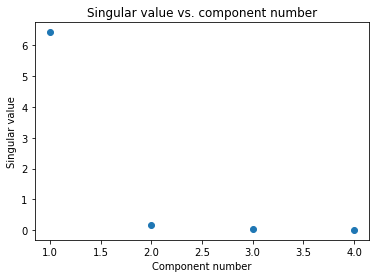

In [21]:
## Put your code below 


_=plt.scatter(range(1, len(iris_kernel_pca.lambdas_) + 1), iris_kernel_pca.lambdas_)
_=plt.xlabel('Component number')
_=plt.ylabel('Singular value')
_=plt.title('Singular value vs. component number')

> Examine the plot of the singular values and answers these questions. 
> 1. Does this plot indicate the dimensionality of the iris data can be reduced to 2 dimensions using the cosine kernel PCA, and why?   
> 2. Compare the foregoing plot to the plot of singular values created in exercise 06-1. What evidence is there that the first components of the kernel PCA explain the variance of the data more completely than conventional PCA? 
> **End of exercise.**

> **Answers:** 
> 1.     
> 2.    

> **Exercise 06-6:** Now you will create and plot the results of a kernel PCA decomposition of the iris data by the following steps:  
> 1. Instantiate a [sklearn.decomposition.KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) object with arguments `n_components=2` and `kernel='cosine'`.  
> 2. Use the `fit_transform` method with the iris data as the argument to compute the projection into the new space. 
> 3. Display a plot of the two components using the `plot_pca` function. 

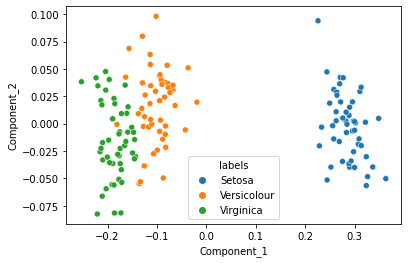

In [22]:
## Put your code below 




> Examine the plot you have created. Answer the following questions:  
> 1. How well can these clusters be linearly separated?  
> 2. Does the range of values of the components indicate that most of the variance is explained by the first component? 
> **End of Exercise.**

> **Answers:**       
> 1.         
> 2.     

> **Exercise 06-7:** Changing the kernel can have a significant impact on the projected components of the kernel PCA model. To see an example, repeat the steps used in the previous exercise, but the the argument `kernel='rbf'`, the radial basis function.

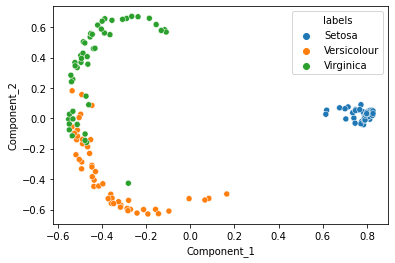

In [23]:
## Put your code below 



> These results are quite different from the cosine kernel projection. Which kernel do you think gives a more useful projection of the iris data with respect to linearly separating the classes?   
> **End of exercise.**

> **Answer:**      

Next, we will try kernel PCA on the gene dataset. Execute the code in the cell below and examine the results. 

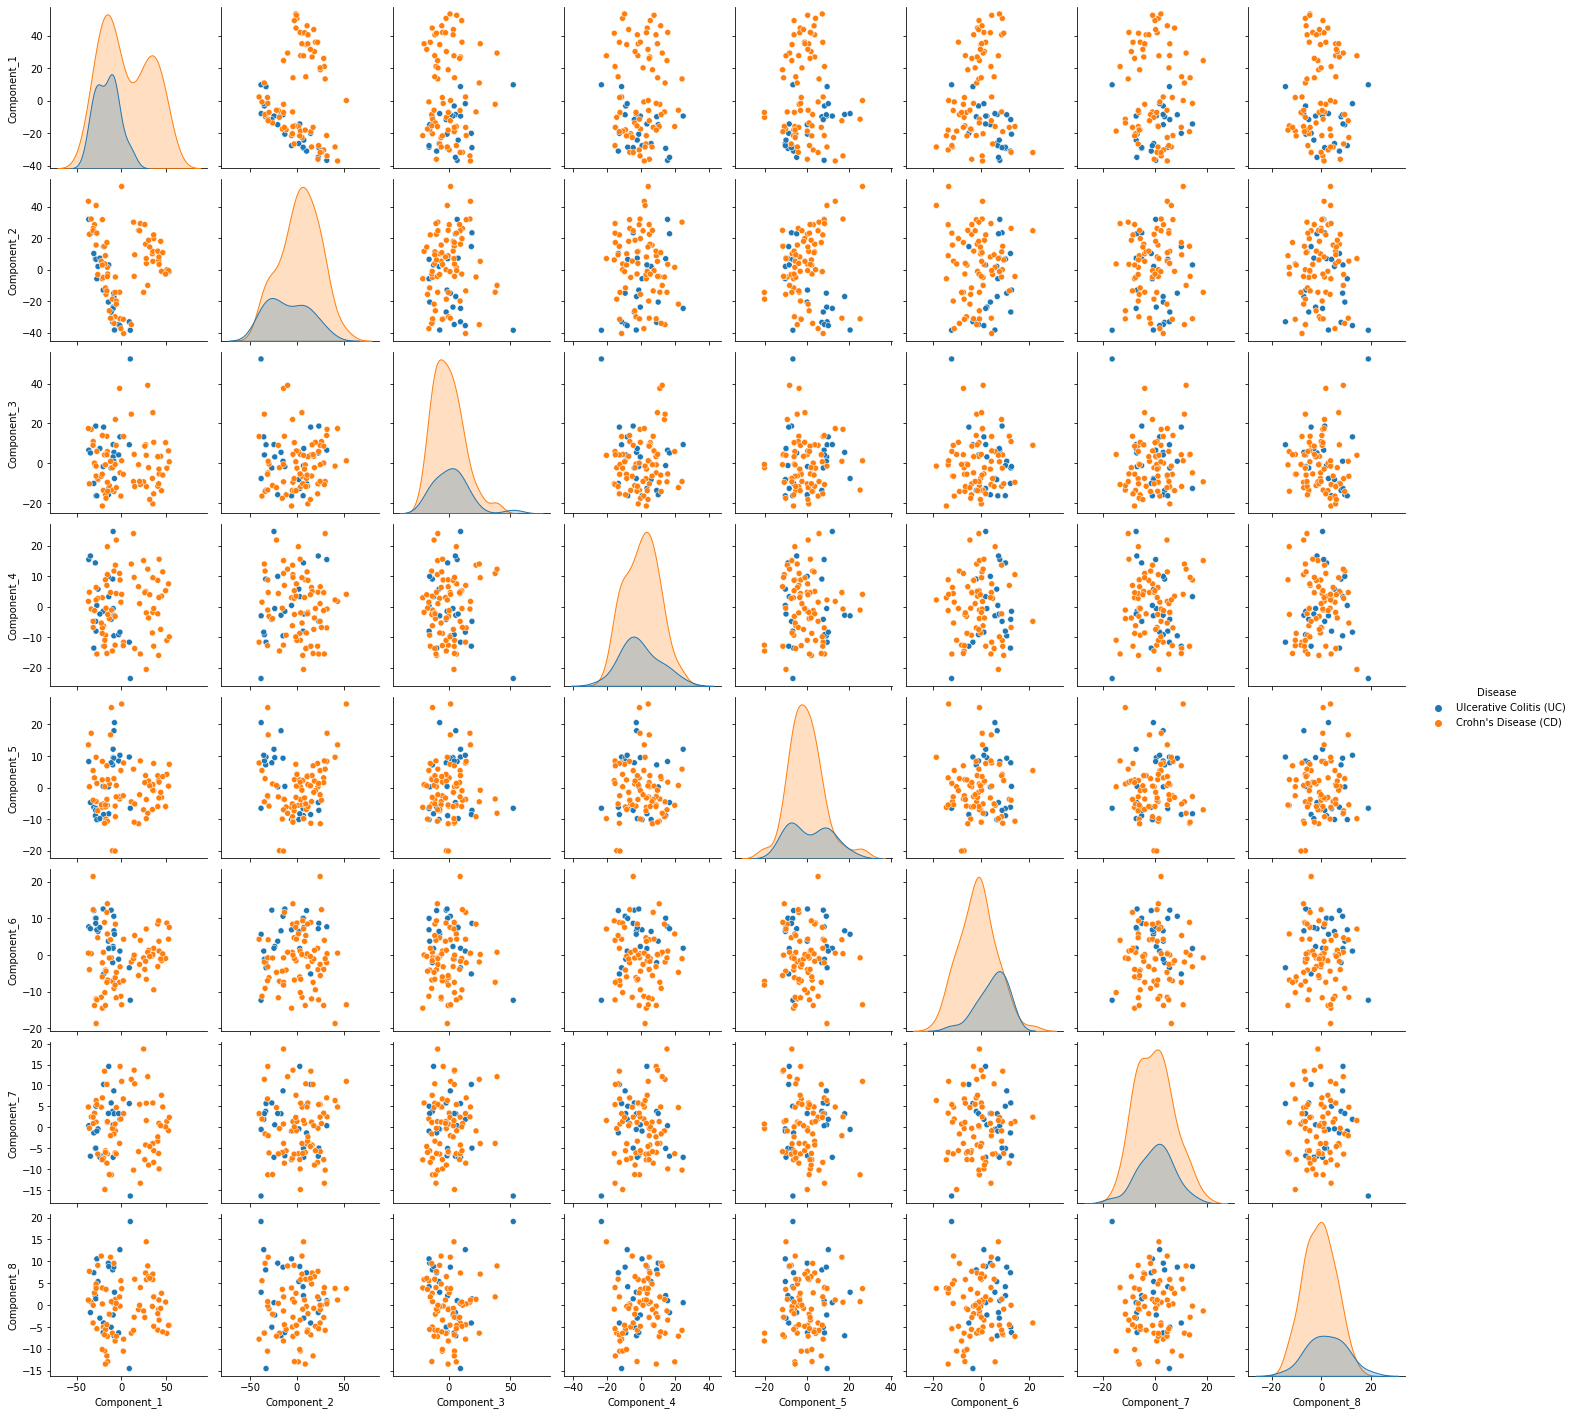

In [28]:
gene_kernel_pca = KernelPCA(n_components=8, kernel='cosine').fit_transform(gene_data) #, kernel='sigmoid').fit_transform(gene_data)
gene_pca_kernel_projected = pd.DataFrame(gene_kernel_pca, columns=['Component_1','Component_2','Component_3','Component_4','Component_5','Component_6','Component_7','Component_8'])
gene_pca_kernel_projected['Disease'] = labels 
_=sns.pairplot(gene_pca_projected, hue='Disease')

Compare this plot to the one created with linear PCA. Overall, these results seem nearly identical. It may be the case that a nonlinear transformation is not required for these data.

## Spectral Manifold Learning  

Manifold learning seeks to map high-dimensional data onto a low-dimensional linear or nonlinear manifold. In this case we will map to a two dimensional manifold which can be displayed as a plot.  

> **Exercise 06-8:** You will now apply the spectral manifold learning to the iris dataset by these steps:   
> 1. Instantiate a [sklearn.manifold.SpectralEmbedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html#sklearn.manifold.SpectralEmbedding) object with argument `affinity='rbf'`.
> 2. Use the `fit_transform` method with the iris data as the argument. 
> 3. Display the result using the `plot_pca` function.  

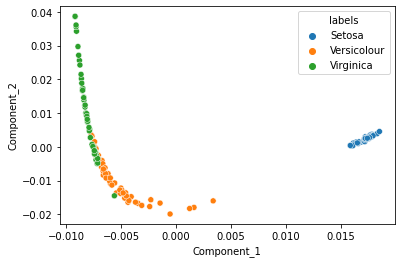

In [25]:
## Put your code below 



> Examine this plot. Which aspects of the data are well separated?  
> **End of exercise.**

> **Answer:**     

We can also apply spectral manifold learning to the gene data. Execute the code in the cell below and examine the results. 

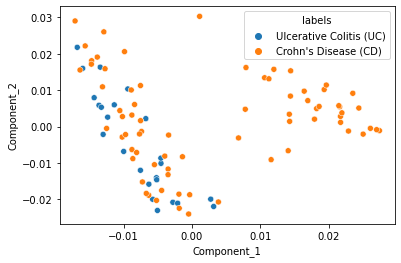

In [26]:
gene_spectral = SpectralEmbedding(affinity='rbf').fit_transform(gene_data)
pca_projected=plot_pca(gene_spectral, labels)

Notice that this result looks remarkably like the plot of the first two components of the linear PCA. This again indicates that the dependency relationship may be primarily linear.  

#### Copyright 2021, 2022, Stephen F Elston. All rights reserved.